## Dependencies

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from models import tiramisu
from datasets import camvid
from datasets import joint_transforms
import utils.imgs
import utils.training as train_utils

## CamVid

Clone this repository which holds the CamVid dataset
```
git clone https://github.com/alexgkendall/SegNet-Tutorial
```

In [2]:
CAMVID_PATH = Path('/bigguy/data', 'SegNet-Tutorial/CamVid')
RESULTS_PATH = Path('.results/')
WEIGHTS_PATH = Path('.weights/')
RESULTS_PATH.mkdir(exist_ok=True)
WEIGHTS_PATH.mkdir(exist_ok=True)
batch_size = 2

In [3]:
normalize = transforms.Normalize(mean=camvid.mean, std=camvid.std)
train_joint_transformer = transforms.Compose([
    #joint_transforms.JointRandomCrop(224), # commented for fine-tuning
    joint_transforms.JointRandomHorizontalFlip()
    ])
train_dset = camvid.CamVid(CAMVID_PATH, 'train',
      joint_transform=train_joint_transformer,
      transform=transforms.Compose([
          transforms.ToTensor(),
          normalize,
    ]))
train_loader = torch.utils.data.DataLoader(
    train_dset, batch_size=batch_size, shuffle=True)

val_dset = camvid.CamVid(
    CAMVID_PATH, 'val', joint_transform=None,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))
val_loader = torch.utils.data.DataLoader(
    val_dset, batch_size=batch_size, shuffle=False)

test_dset = camvid.CamVid(
    CAMVID_PATH, 'test', joint_transform=None,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))
test_loader = torch.utils.data.DataLoader(
    test_dset, batch_size=batch_size, shuffle=False)

Train: 367
Val: 101
Test: 233
Classes: 12
Inputs:  torch.Size([2, 3, 360, 480])
Targets:  torch.Size([2, 360, 480])


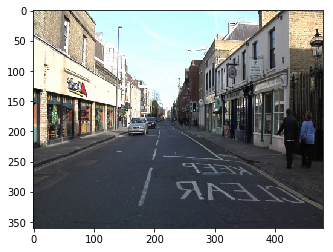

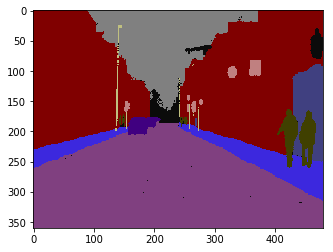

In [4]:
print("Train: %d" %len(train_loader.dataset.imgs))
print("Val: %d" %len(val_loader.dataset.imgs))
print("Test: %d" %len(test_loader.dataset.imgs))
print("Classes: %d" % len(train_loader.dataset.classes))

inputs, targets = next(iter(train_loader))
print("Inputs: ", inputs.size())
print("Targets: ", targets.size())

utils.imgs.view_image(inputs[0])
utils.imgs.view_annotated(targets[0])

## Train

In [5]:
LR = 1e-4
LR_DECAY = 0.995
DECAY_EVERY_N_EPOCHS = 1
N_EPOCHS = 2
torch.cuda.manual_seed(0)

In [6]:
model = tiramisu.FCDenseNet67(n_classes=12).cuda()
model.apply(train_utils.weights_init)
optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = nn.NLLLoss2d(weight=camvid.class_weight.cuda()).cuda()

In [7]:
for epoch in range(1, N_EPOCHS+1):
    since = time.time()

    ### Train ###
    trn_loss, trn_err = train_utils.train(
        model, train_loader, optimizer, criterion, epoch)
    print('Epoch {:d}\nTrain - Loss: {:.4f}, Acc: {:.4f}'.format(
        epoch, trn_loss, 1-trn_err))    
    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    ### Test ###
    val_loss, val_err = train_utils.test(model, val_loader, criterion, epoch)    
    print('Val - Loss: {:.4f} | Acc: {:.4f}'.format(val_loss, 1-val_err))
    time_elapsed = time.time() - since  
    print('Total Time {:.0f}m {:.0f}s\n'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    ### Checkpoint ###    
    train_utils.save_weights(model, epoch, val_loss, val_err)

    ### Adjust Lr ###
    train_utils.adjust_learning_rate(LR, LR_DECAY, optimizer, 
                                     epoch, DECAY_EVERY_N_EPOCHS)

Epoch 1
Train - Loss: 1.4619, Acc: 0.6093
Train Time 1m 24s
Val - Loss: 1.8090 | Acc: 0.4914
Total Time 1m 32s

Epoch 2
Train - Loss: 1.2426, Acc: 0.6631
Train Time 1m 25s
Val - Loss: 1.8074 | Acc: 0.5925
Total Time 1m 32s



## Test

In [8]:
train_utils.test(model, test_loader, criterion, epoch=1)  

(1.665900104575687, 0.40780239316239314)

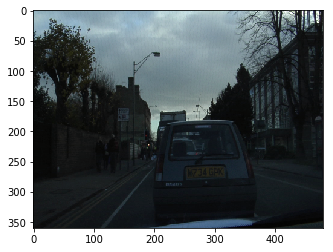

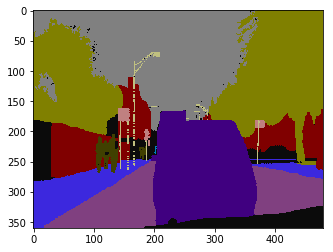

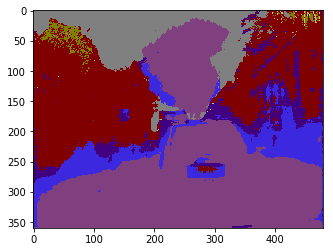

In [9]:
train_utils.view_sample_predictions(model, test_loader, n=1)